OrderedDict([   ('aux_operator_eigenvalues', None),
                ('cost_function_evals', 171),
                (   'eigenstate',
                    array([-1.17810836e-04-2.35185790e-08j, -5.90808785e-03+3.75405676e-07j,
        1.97821593e-02+5.21494974e-06j,  9.92054216e-01+4.44278409e-07j,
        7.25065574e-07+1.83423164e-09j,  3.63612878e-05+8.24155266e-08j,
       -3.34924994e-07-8.51143566e-10j, -1.67961418e-05-3.82636858e-08j,
        1.90712954e-06+4.27264507e-09j,  3.80292908e-08+9.52073315e-11j,
       -3.20234850e-04-7.37930943e-07j, -6.38567215e-06-1.63953127e-08j,
       -1.12643473e-01+4.20403720e-06j, -2.24617880e-03-5.07298070e-07j,
        5.20326948e-02-1.34096152e-06j,  1.03756332e-03+2.46316989e-07j])),
                ('eigenvalue', -1.0861927071706245),
                (   'optimal_parameters',
                    {   ParameterVectorElement(θ[0]): -1.0491405036081804e-05,
                        ParameterVectorElement(θ[7]): -0.0006455994728890754,
         

,optimizer,ansatz,# of qubits,# of parameters,rotation blocks,entanglement_blocks,entanglement,repetitions,error (mHa),pass,score
0,L_BFGS_B,TwoLocal,4,8,"[rx, ry]",[cx],"[[1, 2], [2, 3], [3, 0]]",1,2.513309,True,3


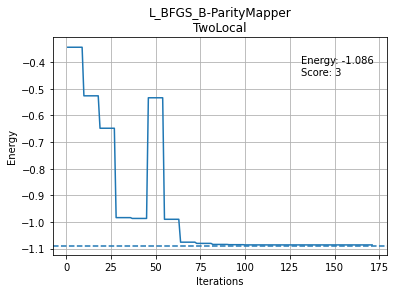

In [3]:
#@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
# Various optimizations I've done to reach score of 3
#@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

# First, to reduce the number of qubits to 6, I've
# - freezed the core
# - changed mapper to ParityMapper
# - set two_qubit_reduction to True
# - found z2symmetry and set z2symmetry_reduction
# With these options, I could reach the score of about 300 with default UCCSD ansatz and L_BFGS_B optimizer

# Second, I tried to further reduce the number of qubits by
# - removing unoccupied orbitals 
# By trial and error, I could figure out which two orbitals to remove
# I added remove_orbitals=[3,4] parameter to FreezeCoreTransformer
# And I could decrease the number of qubits to 4
# With this, I could reach the score of about 12 with default TwoLocal ansatz and L_BFGS_B optimizer

# Third, I could finally reach the score of 3 by 
# - changing the entanglement settings of TwoLocal ansatz
# By trial and error, I figured out the optimal entanglement_map with 3 CNOTs
# I added entangler_map = [[1, 2], [2, 3], [3, 0]] to the ansatz setting
# Finally I could reach the score of 3 with TwoLocal ansatz and L_BFGS_B optimizer


#@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ 1. Driver

from qiskit_nature.drivers import PySCFDriver
from qiskit_nature.transformers import FreezeCoreTransformer

# Get LiH molecule and PySCFDriver
molecule = 'Li 0.0 0.0 0.0; H 0.0 0.0 1.5474'
driver = PySCFDriver(atom=molecule)

# Get molecule data and freeze the core 
qmolecule = FreezeCoreTransformer().transform(driver.run())

# Get attributes of qmolecule
n_el = qmolecule.num_alpha + qmolecule.num_beta
n_mo = qmolecule.num_molecular_orbitals
n_so = 2 * qmolecule.num_molecular_orbitals
n_q = 2* qmolecule.num_molecular_orbitals
e_nn = qmolecule.nuclear_repulsion_energy

#@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ 2. Electronic Structure Problem

# Create an ElectronicStructureProblem that can produce the list of fermionic operators before mapping them to qubits (Pauli strings)
from qiskit_nature.problems.second_quantization.electronic import ElectronicStructureProblem

# Freeze the core and remove unoccupied 2 orbitals --> This decreased the number of qubits to 4
problem = ElectronicStructureProblem(driver, q_molecule_transformers=[FreezeCoreTransformer(freeze_core=True, remove_orbitals=[3,4])])

# Generate the second-quantized operators
second_q_ops = problem.second_q_ops()

# Hamiltonian
main_op = second_q_ops[0]

#@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ 3. ParityMapper and QubitConverter

from qiskit_nature.mappers.second_quantization import ParityMapper
from qiskit_nature.converters.second_quantization.qubit_converter import QubitConverter

# Setup parity mapper 
mapper_type = 'ParityMapper'
mapper = ParityMapper()

# Setup qubit converter
# Set two_qubit_reduction option and z2symmetry_reduction option to true 
# I used "print(qubit_op.z2_symmetries) to check the available symmetries 
# By using these two options and parity mapper, I managed to decrease my qubit number to 6
converter = QubitConverter(mapper=mapper, two_qubit_reduction=True, z2symmetry_reduction = [1, 1])

# The fermionic operators are mapped to qubit operators
num_particles = (problem.molecule_data_transformed.num_alpha,
             problem.molecule_data_transformed.num_beta)
qubit_op = converter.convert(main_op, num_particles=num_particles)

#@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ 4. Initial State

# Initialize Hartree-Fock state
from qiskit_nature.circuit.library import HartreeFock

num_particles = (problem.molecule_data_transformed.num_alpha,
             problem.molecule_data_transformed.num_beta)
num_spin_orbitals = 2 * problem.molecule_data_transformed.num_molecular_orbitals
init_state = HartreeFock(num_spin_orbitals, num_particles, converter)
# Can check initial state by print(init_state)

#@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ 5. Ansatz

from qiskit.circuit.library import TwoLocal

# I used "TwoLocal" ansatz
ansatz_type = "TwoLocal"

# Put arguments for twolocal
# Single qubit rotations that are placed on all qubits with independent parameters
rotation_blocks = ['rx', 'ry']
# Entangling gates
entanglement_blocks = ['cx']
# How the qubits are entangled 
# After I figured out the optimal entangler_map by trial and error, 
# I could decrease my score to 3
entangler_map = [[1, 2], [2, 3], [3, 0]] 
entanglement = entangler_map
# Repetitions of rotation_blocks + entanglement_blocks with independent parameters
repetitions = 1

# Skip the final rotation_blocks layer
skip_final_rotation_layer = True
ansatz = TwoLocal(qubit_op.num_qubits, rotation_blocks, entanglement_blocks, reps=repetitions, 
                  entanglement=entanglement, skip_final_rotation_layer=skip_final_rotation_layer)
# Add the initial state
ansatz.compose(init_state, front=True, inplace=True)

# Can check ansatz by print(ansatz)

#@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ 6. Backend

from qiskit import Aer
backend = Aer.get_backend('statevector_simulator')

#@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ 7. Optimizer

# I used "L_BFGS_B" optimizer with 9999 maxfun
from qiskit.algorithms.optimizers import L_BFGS_B

optimizer_type = 'L_BFGS_B'
optimizer = L_BFGS_B(maxfun=9999)

#@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ 8. Exact Eigensolver

# We can solve the problem exactly with the exact diagonalization of the Hamiltonian matrix so we know where to aim with VQE
from qiskit_nature.algorithms.ground_state_solvers.minimum_eigensolver_factories import NumPyMinimumEigensolverFactory
from qiskit_nature.algorithms.ground_state_solvers import GroundStateEigensolver
import numpy as np 

def exact_diagonalizer(problem, converter):
    solver = NumPyMinimumEigensolverFactory()
    calc = GroundStateEigensolver(converter, solver)
    result = calc.solve(problem)
    return result

result_exact = exact_diagonalizer(problem, converter)
exact_energy = np.real(result_exact.eigenenergies[0])
print("Exact electronic energy", exact_energy)

#@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ 9. VQE and initial parameters for the ansatz

from qiskit.algorithms import VQE
from IPython.display import display, clear_output

# Print and save the data in lists
def callback(eval_count, parameters, mean, std):  
    # Overwrites the same line when printing
    display("Evaluation: {}, Energy: {}, Std: {}".format(eval_count, mean, std))
    clear_output(wait=True)
    counts.append(eval_count)
    values.append(mean)
    params.append(parameters)
    deviation.append(std)

counts = []
values = []
params = []
deviation = []

# Set initial parameters of the ansatz
# We choose a fixed small displacement 
# So all participants start from similar starting point
try:
    initial_point = [0.01] * len(ansatz.ordered_parameters)
except:
    initial_point = [0.01] * ansatz.num_parameters

algorithm = VQE(ansatz,
                optimizer=optimizer,
                quantum_instance=backend,
                callback=callback,
                initial_point=initial_point)

result = algorithm.compute_minimum_eigenvalue(qubit_op)
print(result)

#@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ 10. Scoring Function

# Store results in a dictionary
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import Unroller

# Unroller transpile your circuit into CNOTs and U gates
pass_ = Unroller(['u', 'cx'])
pm = PassManager(pass_)
ansatz_tp = pm.run(ansatz)
cnots = ansatz_tp.count_ops()['cx']
score = cnots

accuracy_threshold = 4.0 # in mHa
energy = result.optimal_value


result_dict = {
    'optimizer': optimizer.__class__.__name__,
    'mapping': converter.mapper.__class__.__name__,
    'ansatz': ansatz.__class__.__name__,
    'rotation blocks': rotation_blocks,
    'entanglement_blocks': entanglement_blocks,
    'entanglement': entanglement,
    'repetitions': repetitions,
    'skip_final_rotation_layer': skip_final_rotation_layer,
    'energy (Ha)': energy,
    'error (mHa)': (energy-exact_energy)*1000,
    'pass': (energy-exact_energy)*1000 <= accuracy_threshold,
    '# of parameters': len(result.optimal_point),
    'final parameters': result.optimal_point,
    '# of evaluations': result.optimizer_evals,
    'optimizer time': result.optimizer_time,
    '# of qubits': int(qubit_op.num_qubits),
    '# of CNOTs': cnots,
    'score': score}

# Plot the results
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1)
ax.set_xlabel('Iterations')
ax.set_ylabel('Energy')
ax.grid()
fig.text(0.7, 0.75, f'Energy: {result.optimal_value:.3f}\nScore: {score:.0f}')
plt.title(f"{result_dict['optimizer']}-{result_dict['mapping']}\n{result_dict['ansatz']}")
ax.plot(counts, values)
ax.axhline(exact_energy, linestyle='--')
fig_title = f"\
{result_dict['optimizer']}-\
{result_dict['mapping']}-\
{result_dict['ansatz']}-\
Energy({result_dict['energy (Ha)']:.3f})-\
Score({result_dict['score']:.0f})\
.png"
fig.savefig(fig_title, dpi=300)

# Display and save the data
import pandas as pd
import os.path
filename = 'results_h2.csv'
if os.path.isfile(filename):
    result_df = pd.read_csv(filename)
    result_df = result_df.append([result_dict])
else:
    result_df = pd.DataFrame.from_dict([result_dict])
result_df.to_csv(filename)
result_df[['optimizer','ansatz', '# of qubits', '# of parameters','rotation blocks', 'entanglement_blocks',
    'entanglement', 'repetitions', 'error (mHa)', 'pass', 'score']]

